In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from util import rand_genome, World
from genetics import get_proteome, assert_config, Signal
assert_config()

In [2]:
def prot_dom_stats(len_range):
    genomes = [rand_genome(len_range) for _ in range(100)]
    protstats = []
    domstats = []
    for genome in genomes:
        proteins = get_proteome(genome)
        protstats.append(len(proteins))
        if len(proteins) > 0:
            domstats.extend([len(d) for d in proteins])
    return protstats, domstats

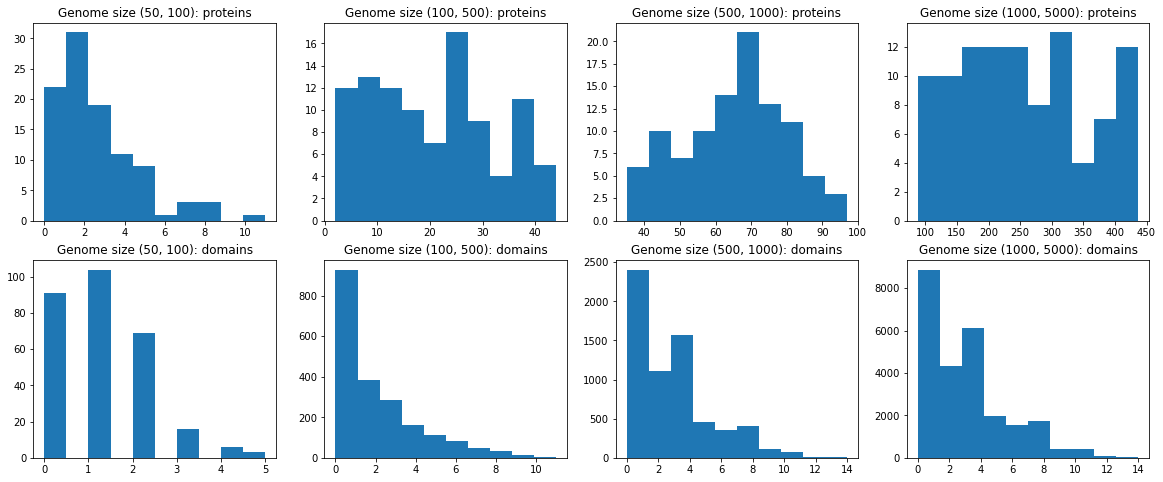

In [3]:
sizes = [(50, 100), (100, 500), (500, 1000), (1000, 5000)]
fig, axs = plt.subplots(2, len(sizes), figsize=(20, 8))

for idx, size in enumerate(sizes):
    n_prots, n_doms = prot_dom_stats(size)
    axs[0, idx].title.set_text(f"Genome size {size}: proteins")
    axs[0, idx].hist(n_prots)
    axs[1, idx].title.set_text(f"Genome size {size}: domains")
    axs[1, idx].hist(n_doms)

In [4]:
def plot_proteomes(proteomes, title="", scale_n=100, scale_w=5, figsize=(24, 6)):
    node_types = {
        "migration": [Signal.CM],
        "external signal": [Signal.F, Signal.CK, Signal.CL],
        "messenger": [Signal.MA, Signal.MB, Signal.MC, Signal.MD]
    }
    vm = {d: k for k, v in node_types.items() for d in v}

    cmap = {
        "migration": "tab:orange",
        "external signal": "tab:blue",
        "messenger": "gray",
        "protein": "lightgray"
    }

    fig, axs = plt.subplots(1, len(proteomes), sharey=True, sharex=True, figsize=figsize)
    fig.suptitle(title)
    patches = [mpatches.Patch(color=v, label=k) for k, v in cmap.items()]
    fig.legend(handles=patches, ncol=len(patches), loc="upper right")

    for proteome, ax in zip(proteomes, axs):
        edges = []
        cols = []
        ws = []
        for idx, prot in enumerate(proteome):
            name = f"P{idx}"
            for (_, sig, inc), weight in prot.items():
                edge = (sig, name, weight) if inc else (name, sig, weight)
                cols.append(weight)
                ws.append(abs(weight) * scale_w)
                edges.append(edge)

        G = nx.DiGraph()
        G.add_weighted_edges_from(edges)
        pos = nx.spring_layout(G, k=1)
        cm = [cmap[vm.get(d, "protein")] for d in G]
        sizes = [4 * scale_n if isinstance(d, str) else 1 * scale_n for d in G]
        nx.draw(G, pos, node_size=sizes, edge_cmap=plt.cm.coolwarm, edge_color=cols, node_color=cm, connectionstyle="arc3,rad=0.1", ax=ax)

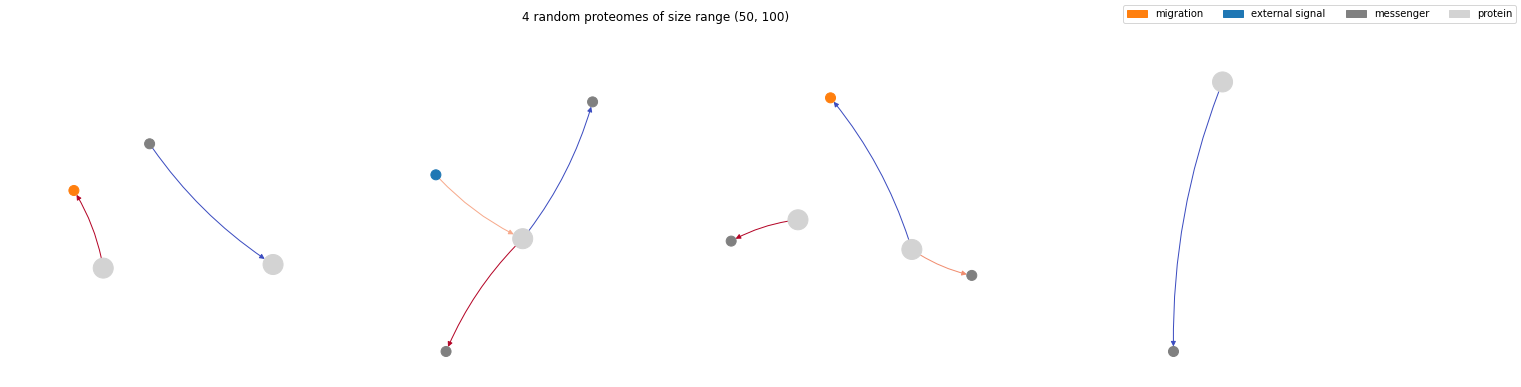

In [5]:
n = 4
size_range = (50, 100)
proteomes = []
for _ in range(n):
    genome = rand_genome(size_range)
    proteomes.append(get_proteome(genome))
plot_proteomes(proteomes, title=f"{n} random proteomes of size range {size_range}")

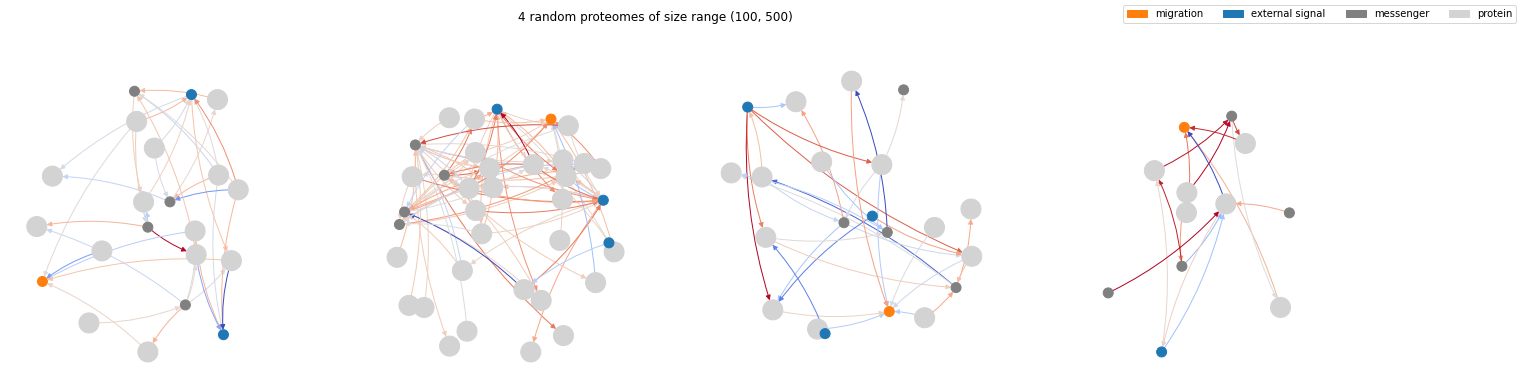

In [6]:
n = 4
size_range = (100, 500)
proteomes = []
for _ in range(n):
    genome = rand_genome(size_range)
    proteomes.append(get_proteome(genome))
plot_proteomes(proteomes, title=f"{n} random proteomes of size range {size_range}")

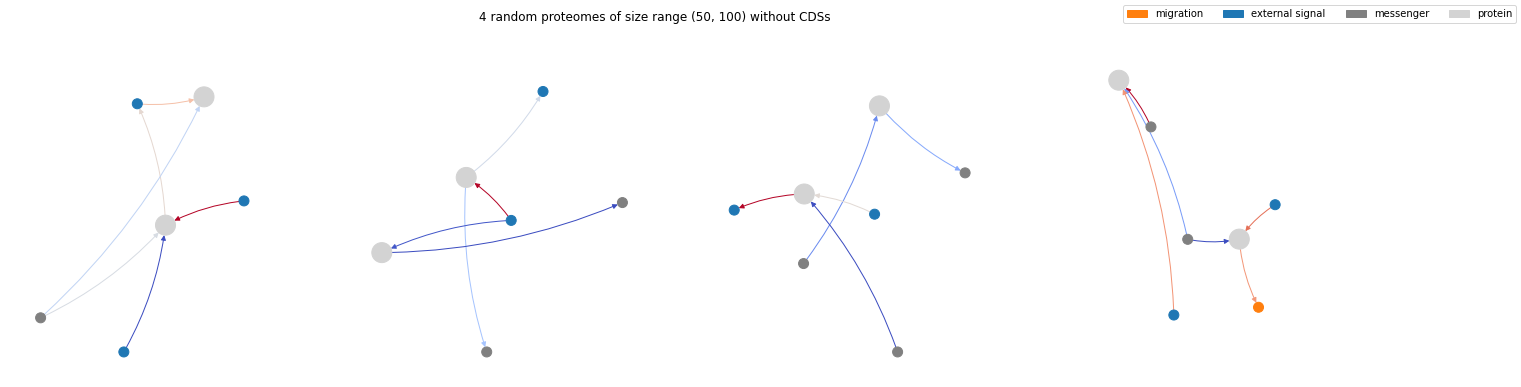

In [7]:
n = 4
size_range = (50, 100)
proteomes = []
for _ in range(n):
    genome = rand_genome(size_range)
    proteomes.append(get_proteome(genome, ignore_cds=True))
plot_proteomes(proteomes, title=f"{n} random proteomes of size range {size_range} without CDSs")

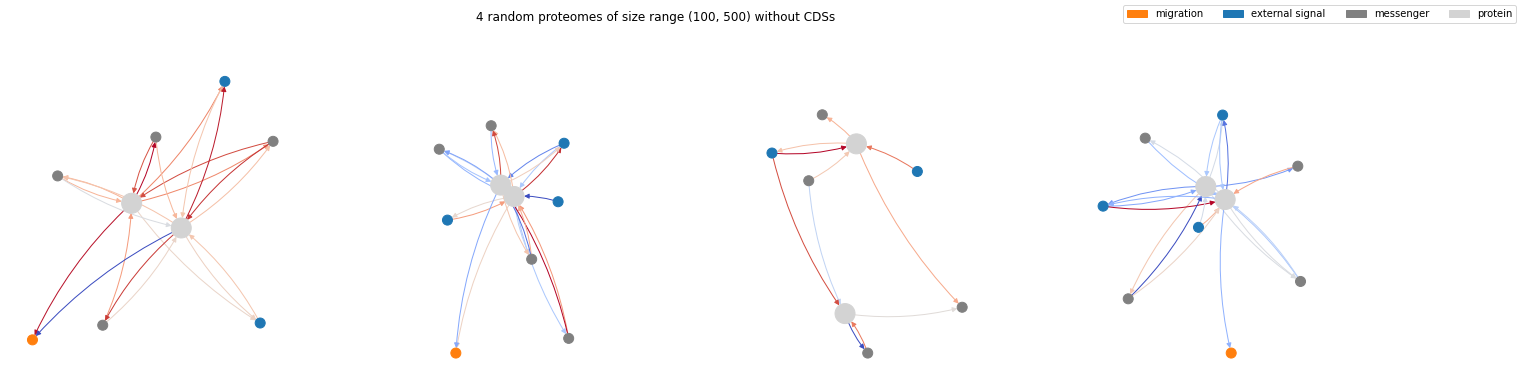

In [8]:
n = 4
size_range = (100, 500)
proteomes = []
for _ in range(n):
    genome = rand_genome(size_range)
    proteomes.append(get_proteome(genome, ignore_cds=True))
plot_proteomes(proteomes, title=f"{n} random proteomes of size range {size_range} without CDSs")

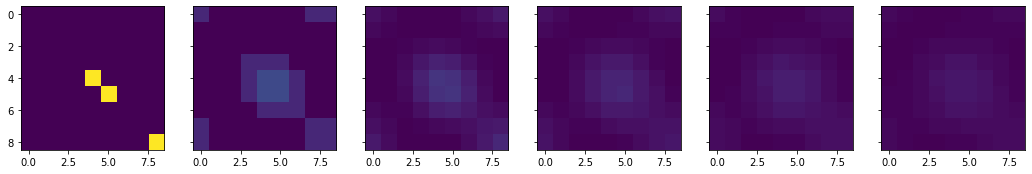

In [19]:
world = World(size=9, layers=1, degrad=1.0)
world.map[0, 0, 4, 4] = 1.0
world.map[0, 0, 5, 5] = 1.0
world.map[0, 0, 8, 8] = 1.0
n = 6
fig, axs = plt.subplots(1, n, sharey=True, sharex=True, figsize=(n * 3, 3))
for i in range(n):
    axs[i].imshow(world.map[0, 0], interpolation='nearest', vmin=0, vmax=1)
    world.step()

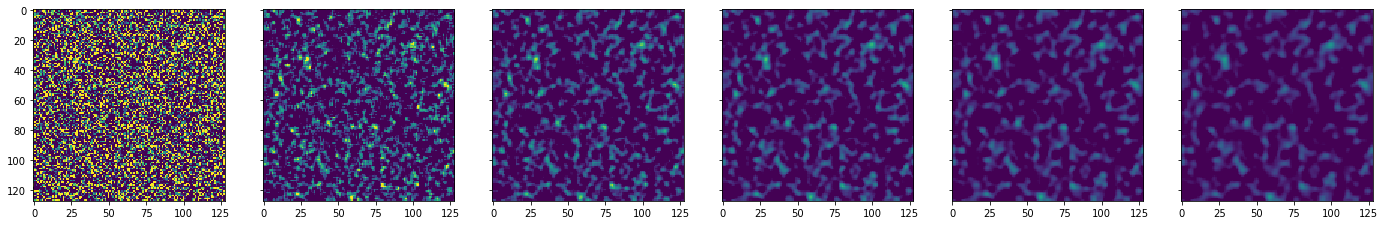

In [22]:
world = World(size=128, layers=1, degrad=1.0)
world.map = torch.randn(1, 1, 128, 128)
n = 6
fig, axs = plt.subplots(1, n, sharey=True, sharex=True, figsize=(n * 4, 4))
for i in range(n):
    axs[i].imshow(world.map[0, 0], interpolation='nearest', vmin=0, vmax=1)
    world.step()

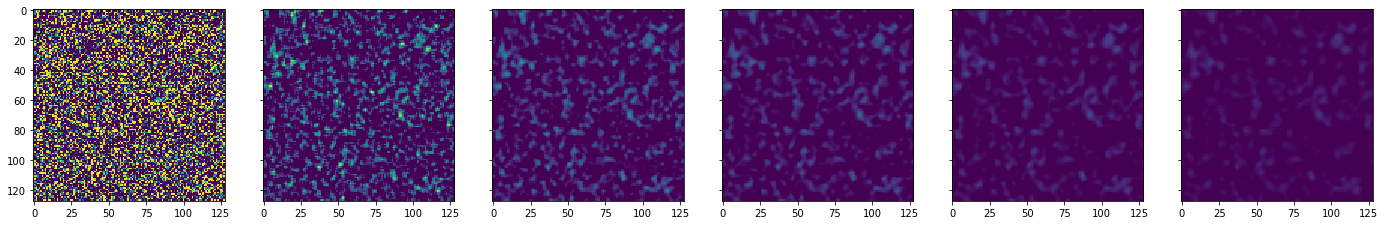

In [23]:
world = World(size=128, layers=1, degrad=0.8)
world.map = torch.randn(1, 1, 128, 128)
n = 6
fig, axs = plt.subplots(1, n, sharey=True, sharex=True, figsize=(n * 4, 4))
for i in range(n):
    axs[i].imshow(world.map[0, 0], interpolation='nearest', vmin=0, vmax=1)
    world.step()